In [1]:
class schilthuis():
    def calculate_aquifer(self, pressure, Bw, Wp, Np, Bo, Nfoi, cf, cw, swi, Boi):
        """Calculate Material Balance parameters of Undersaturated Oil Reservoir for Schilthuis Method"""
        # in case of undersaturated (above bubblepoint), Rp = Rs = Rsi, Gfgi = Bgi = Eg = 0

        import numpy as np

        F = Np * Bo
        Eo = Bo - Boi

        delta_pressure = pressure - pressure[0]
        delta_pressure = np.abs(delta_pressure)

        Efw = ((cf + (cw * swi)) / (1 - swi)) * delta_pressure

        We_schilthuis = (Bw * Wp) + F - (Nfoi * Eo) - ((Nfoi * Boi) * Efw)

        return We_schilthuis

class fetkovich():
    def initial_encroachable_water(self, pi, ct, r_R, r_aq, h_aq, poro, theta):
        "calculate initial encroachable water"
        import numpy as np
        # r_R: reservoir size (radius of cylindrical-assumed reservoir), in ft
        # r_aq: aquifer size, in ft
        # theta: for full circle cylindrical, theta=360. if half-circle, theta=180
        Wei = (pi * ct * np.pi * ((r_aq ** 2) - (r_R ** 2)) * h_aq * poro * theta) / (5.61458 * 360)
        return Wei

    def productivity_index(self, perm, h_aq, mu_w, r_aq, r_R, theta, flow='constant'):
        "calculate productivity index"
        import numpy as np

        if flow == 'constant':
            # mu_w: water viscosity
            J = (0.007082 * perm * h_aq * theta) / ((mu_w * (np.log(r_aq / r_R)) * 360))
            return J

        if flow == 'no flow':
            # mu_w: water viscosity
            J = (0.007082 * perm * h_aq * theta) / ((mu_w * (np.log(r_aq / r_R) - 0.75) * 360))
            return J

    def calculate_aquifer(self, datetime, pressure, Wei, J):
        """
        Calculate aquifer influx (We) using Fetkovich Pseudo-steady Method
        """
        import numpy as np

        "Subtracting datetimes to get time differences (how many days) IN INTEGER"
        diff = [j - i for i, j in zip(datetime[:-1], datetime[1:])]
        diff = np.array(diff)

        # convert datetime format to integer
        diffr_arr = []
        for k in range(len(diff)):
            diffr = diff[k] / np.timedelta64(1, 'D')
            diffr_arr.append(float(diffr))

        # append 0 to the first index of numpy
        diffr_arr = np.append(0, diffr_arr)  # now diff has same dimension with time data (a)
        delta_time = diffr_arr

        "Initial conditions"
        We = 0  # We at initial production date (NOTE: different from Wei, initial encroachable water)
        pi = pressure[0]
        pRn_min_one = pn_min_one = pi

        "Calculate aquifer influx"
        We_fetkovich = []

        for i in range(len(datetime)):
            # calculate p_Rn average, Eq 8.29
            p_Rn = 0.5 * (pRn_min_one + pressure[i])

            # update value of pRn-1 equals to current pressure
            pRn_min_one = pressure[i]

            # calculate (p_n-1 - p_Rn average), Eq 8.30
            pn_min_prn = pn_min_one - p_Rn

            # calculate delta Wen, Eq 8.30
            delta_We = (Wei / pi) * pn_min_prn * (1 - np.exp(-(J * pi * delta_time[i]) / (Wei)))

            # calculate We, Eq 8.31
            We = We + delta_We

            # update p_n-1 for the next timestep, Eq 8.32
            pn_min_one = pi * (1 - (We / Wei))

            We_fetkovich.append(We)

        return We_fetkovich

class veh():
    def calculate_aquifer_constant(self, r_R, h, cf, cw, poro, theta=360):
        """
        Calculate theoretical aquifer constant for VEH (assuming cylindrical reservoir)
        Input:
        r_R = reservoir radius
        """
        import numpy as np

        ct = cf + cw  # total compressibility, in aquifer sw=1
#         theta = 360  # full circle cylindrical
        B_star = 1.119 * poro * ct * h * (r_R ** 2) * (theta / 360)

        return B_star

    def calculate_aquifer(self, datetime, pressure, cf, cw, perm, poro, mu_w, r_R, B_star, rw=0.5):
        import numpy as np

        def qd(rd, td):
            """
            Dimensionless cumulative production (QD) using Klins et al. Polynomial
            Approach to Bessel Functions in Aquifer
            """
            from scipy.special import j1
            from scipy.special import j0
            import math
            import mpmath  
            def csch(x):
                if x > 100:
                    return 0
                else:
                    return float(mpmath.csch(x))

            def beta(b,rd):
                return b[0]+b[1]*csch(rd)+b[2]*rd**b[3]+b[4]*rd**b[5]  

            # Algorithm
            if td < 0.01:
                return 2*td**0.5/3.14159265359**0.5
            else:
                b = [1.129552, 1.160436, 0.2642821, 0.01131791, 0.5900113, 0.04589742, 1.0, 0.5002034, 1.50, 1.979139]
                qd_inf = (b[0]*td**b[7]+b[1]*td+b[2]*td**b[8]+b[3]*td**b[9])/(b[4]*td**b[7]+b[5]*td+b[6])
                if rd > 100:
                    return qd_inf

                b1 = [-0.00222107, -0.627638, 6.277915, -2.734405, 1.2708, -1.100417]
                b2 = [-0.00796608, -1.85408, 18.71169, -2.758326, 4.829162, -1.009021]
                
                alpha1 = beta(b1,rd)
                alpha2 = beta(b2,rd)
                J0Alpha1 = j0(alpha1)
                J0Alpha2 = j0(alpha2)
                J1Alpha1rd = j1(alpha1*rd)
                J1Alpha2rd = j1(alpha2*rd)
                
                qd_fin = (rd**2-1)/2 - (2*math.exp(-alpha1**2*td)*J1Alpha1rd**2)/(alpha1**2*(J0Alpha1**2-J1Alpha1rd**2))-(2*math.exp(-alpha2**2*td)*J1Alpha2rd**2)/(alpha2**2*(J0Alpha2**2-J1Alpha2rd**2))
            return min(qd_inf, qd_fin)        

        def time_pressure_difference(datetime):
            """Calculate time and pressure differences"""

            # Subtracting datetimes to get time differences from initial production date to date[i] (how many days) IN INTEGER
            diff = datetime - datetime[0]

            # convert datetime format to integer
            time_array = []
            for k in range(len(diff)):
                diffr = diff[k] / np.timedelta64(1, 'D')
                time_array.append(float(diffr))

            # convert time difference from day to hour
            time_array = np.array(time_array) * 24

            # create j index for dataframe
            j_index = np.arange(0, (len(datetime)), 1)

            # calculate delta_pressure for each date
            # append an array consists of two initial pressures [pi, pi] (as dummy) to the pressure data
            pi = pressure[0]

            p_dummy = np.append(np.array([pi, pi]), pressure)
            delta_p_j = [b - a for a, b in zip(p_dummy[:-2], p_dummy[2:])]
            delta_p_j = 0.5 * np.array(np.abs(delta_p_j))

            # pre-processing
            j_array = np.arange(1, (len(time_array) + 1), 1)
            delta_p_j_array = delta_p_j[1:]

            array_j = []
            array_time = []
            delta_pressure = []
            array_time_repeat = []

            for i in range(len(time_array)):
                new_j = j_array[:i]
                new_time = time_array[:i]
                new_delta_p_j = delta_p_j_array[:i]

                array_j.append(new_j)
                array_time.append(new_time)
                delta_pressure.append(new_delta_p_j)

                # make arrays of repeated times
                new_time_repeat = np.repeat((time_array[i]), i)
                array_time_repeat.append(new_time_repeat)

            # To calculate delta_time, SUBTRACT arrr_time TO arrr_time_repeat
            delta_time = np.subtract(array_time_repeat, array_time)  # numpy subtract array to array

            return delta_time, delta_pressure


        def calculate_parameter_VEH(index, delta_time, cf, cw, perm, poro, mu_w, r_R):
            """Calculate dimensionless time (t_DR) and dimensionless aquifer influx (W_eD)"""

            # Calculate t_DR and W_eD
            ct = cf + cw
            t_DR_factor = (0.0002637 * perm) / (poro * mu_w * ct * (r_R ** 2))

            t_DR_arr = []
            W_eD_arr = []

            for i in range(len(delta_time[index])):
                t_DR = t_DR_factor * (delta_time[index])[i]

                # Dimensionless radius
                rd = r_R / rw

                # Use Bessel function to calculate dimensionless Qd (W_eD)
                W_eD = qd(rd, t_DR)

                # "calculate W_eD using Eq 6.36 and 6.37 for infinite reservoir (See: 6_examples_part2.ipynb)"
                # if t_DR > 0.01 and t_DR <= 200:
                #     # use Eq 6.36
                #     W_eD = ((1.12838 * np.sqrt(t_DR)) + (1.19328 * t_DR) + (0.269872 * t_DR * np.sqrt(t_DR)) + (
                #                 0.00855294 * (t_DR ** 2))) / (1 + (0.616599 * np.sqrt(t_DR) + (0.0413008 * t_DR)))
                # if t_DR > 200:
                #     # use Eq 6.37
                #     W_eD = ((2.02566 * t_DR) - 4.29881) / np.log(t_DR)

                W_eD_arr.append(float(W_eD))
                t_DR_arr.append(float(t_DR))
            return (t_DR_arr, W_eD_arr)

        # Calculate time differences
        delta_time, delta_pressure = time_pressure_difference(datetime)

        # Calculate aquifer influx
        We_veh = []

        for x in range(len(datetime)):  # range from j index 1 to 9

            t_DR_arr, W_eD_arr = calculate_parameter_VEH(x, delta_time, cf, cw, perm, poro, mu_w, r_R)  # call function

            # calculate We, Equation 8.7

            W_eD_multipy_delta_p_j = delta_pressure[x] * W_eD_arr
            sigma_We = np.sum(W_eD_multipy_delta_p_j)
            We = B_star * sigma_We
            We_veh.append(float(We))

        return We_veh      

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
# reservoir rock and fluid properties
Nfoi = 48.75 # OOIP, in MMSTB (million STB)
Boi = 1.078 # Initial oil FVF, in RB/STB
Bob = 1.094 # Oil FVF at bubble-point pressure, in RB/STB
Bw = 1.02 # Water FVF, in RB/STB
swi = 0.48 # Initial water saturation
cf = 4E-06 # Formation compressibility, in psi^-1
cw = 3E-06 # Water compressibility, in psi^-1
poro = 0.177 # Porosity
perm = 432 # Permeability, in md
mu_w = 0.38 # Water viscosity, in cp

# reservoir and aquifer dimension
h = 31.8 # reservoir thicknes, ft
vbulk = 73590 # reservoir bulk volume, acre ft
r_R = 5664.5 # Reservoir radius, in ft
r_aq = 275000 # Aquifer radius, in ft
h_aq = 71.73 # Aquifer thickness, in ft
theta = 360 # reservoir is cylindrical (full circle)



# conversion
Nfoi = Nfoi * 1E+06 # convert from MMSTB to STB

"""""""""""
CALCULATION
"""""""""""

# load data
data = pd.read_csv('Production_Data_Moonie_Field.csv')

# convert time column to DateTime format (check: https://strftime.org/)
# time data in format: 01 January 1964
data['t'] = pd.to_datetime(data['t'], format='%d %B %Y')

datetime = data['t'].values
pressure = data['p'].values
     


In [6]:
method1 = schilthuis()

# Calculate water influx using Schilthuis function
Np = np.array(data['Np'])
Wp = np.array(data['Wp'])
Bo = np.array(data['Bo'])

We_schilthuis = schilthuis.calculate_aquifer(method1, pressure, Bw, Wp, Np, Bo, Nfoi, cf, cw, swi, Boi)

In [9]:
method2 = veh()

# calculate aquifer constant
# there are 2 ways: 1. Using "calculate_aquifer_constant" functon, 2. Using MBAL
B = 3191.2 # Aquifer constant, from material balance

# Calculate water influx using VEH method
We_veh = veh.calculate_aquifer(method2, datetime, pressure, cf, cw, perm, poro, mu_w, r_R, B)

<ipython-input-1-420dc6ccef9e>:202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  delta_time = np.subtract(array_time_repeat, array_time)  # numpy subtract array to array


In [10]:
method3 = fetkovich()

# calculate initial encroachable water, Wei
pi = data['p'].iloc[0]
ct = cf + cw
Wei = fetkovich.initial_encroachable_water(method3, pi, ct, r_R, r_aq, h_aq, poro, theta)

# calculate productivity index
# flowing aquifer
J = fetkovich.productivity_index(method3, perm, h_aq, mu_w, r_aq, r_R, theta, flow='no flow')

# Calculate water influx using Fetkovich function
We_fetkovich = fetkovich.calculate_aquifer(method3, datetime, pressure, Wei, J)

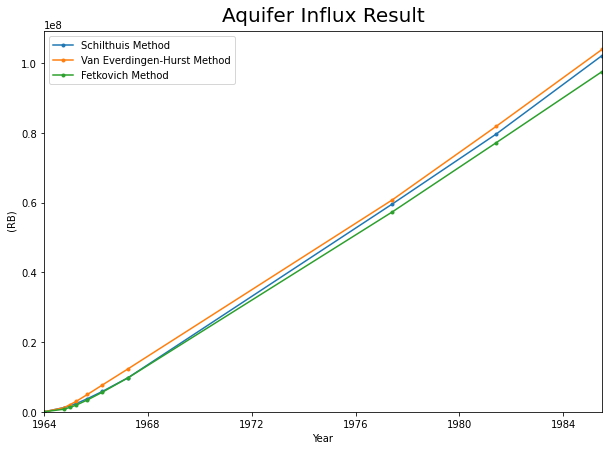

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(10,7))

plt.plot(datetime, We_schilthuis, '.-', label='Schilthuis Method')
plt.plot(datetime, We_veh, '.-', label='Van Everdingen-Hurst Method')
plt.plot(datetime, We_fetkovich, '.-', label='Fetkovich Method')
plt.title('Aquifer Influx Result', size=20, pad=10)
plt.xlabel('Year'); plt.ylabel(' (RB)')
plt.xlim(np.min(datetime), np.max(datetime))
plt.ylim(ymin=0)
plt.legend()
plt.show()